# prepare data

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import math
import warnings

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

warnings.filterwarnings("ignore")

# processed data from the source below
# "https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx"
data_path = "dataset_grouped_by_date.csv"

df = pd.read_csv(data_path)

df.rename(columns={'total_price': 'daily_sale',
                  'InvoiceNo': 'unique_invoices',
                  'StockCode': 'unique_stocks',
                  'CustomerID': 'unique_customers'}, inplace=True)

In [2]:
# remove outliers
df = df[df.daily_sale < df.daily_sale.quantile(0.99)]

In [3]:
# normalize some columns

df['unique_invoices'] = df['unique_invoices'] / df['unique_invoices'].max()
df['unique_stocks'] = df['unique_stocks'] / df['unique_stocks'].max()
df['unique_customers'] = df['unique_customers'] / df['unique_customers'].max()

# adding new features

In [4]:
df['is_weekend'] = (pd.to_datetime(df.date).dt.dayofweek > 3).astype(int).shift(-1).fillna(0)

In [5]:
df['month'] = pd.to_datetime(df.date).dt.month / 12

In [6]:
df['three_days_to_week_day_ratio'] = ((df['daily_sale'].rolling(3).mean()) / (df['daily_sale'].rolling(7).mean())).fillna(1)

In [7]:
df['daily_sale_change'] = df['daily_sale'].pct_change().fillna(0)

In [8]:
df['target'] = df['daily_sale'].shift(-1).fillna(0)

In [9]:
features_list = ['unique_invoices', 'unique_stocks', 'unique_customers', 
                 'is_weekend', 'month', 'three_days_to_week_day_ratio',
                 'daily_sale', 'daily_sale_change']

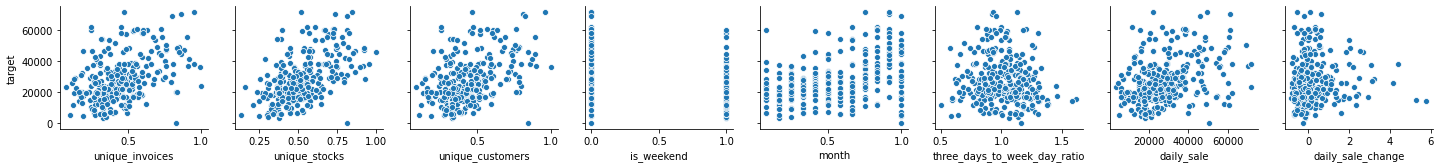

In [10]:
sns.pairplot(df, y_vars="target", x_vars=features_list)

# create multi-feature dataset

In [11]:
train_df = df[df.date < '2011-10-01']
test_df = df[df.date > '2011-11-01']

In [12]:
# normalize data

scaler = MinMaxScaler(feature_range=(0, 1))
train_df['daily_sale'] = scaler.fit_transform(train_df.daily_sale.values.reshape(-1, 1))
test_df['daily_sale'] = scaler.transform(test_df.daily_sale.values.reshape(-1, 1))

scaler = MinMaxScaler(feature_range=(0, 1))
train_df['target'] = scaler.fit_transform(train_df.target.values.reshape(-1, 1))
test_df['target'] = scaler.transform(test_df.target.values.reshape(-1, 1))

In [13]:
# source: machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=6):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        this_chunk = dataset[i:(i+look_back), :]
        dataX.append(this_chunk)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [14]:
trainX, trainY = train_df[features_list].values, train_df['target'].values
testX, testY = test_df[features_list].values, test_df['target'].values

In [15]:
# create and fit the Dense network

def build_model(input_shape=(len(features_list),)):
    model = Sequential()
    model.add(Dense(256, input_shape=input_shape, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='relu'))
    opt = keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(loss='mean_squared_error', optimizer=opt)

    print(model.summary())

    return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               2304      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 35,329
Trainable params: 35,329
Non-trainable params: 0
_________________________________________________________________
None


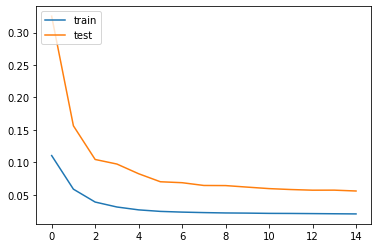

In [16]:
model = build_model()
history = model.fit(trainX, trainY, epochs=15, batch_size=16, verbose=0, validation_data=(testX, testY))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'test'], loc='upper left')

In [17]:
trainPredict = model.predict(trainX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])

<BarContainer object of 20 artists>

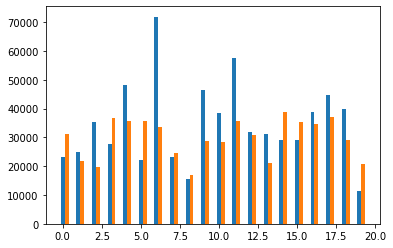

In [18]:
x = np.arange(20)
plt.bar(x, trainY.reshape(-1)[-20:],  width = 0.25)
plt.bar(x+0.25, trainPredict.reshape(-1)[-20:],  width = 0.25)

In [19]:
testPredict = model.predict(testX)
# invert predictions
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

<BarContainer object of 20 artists>

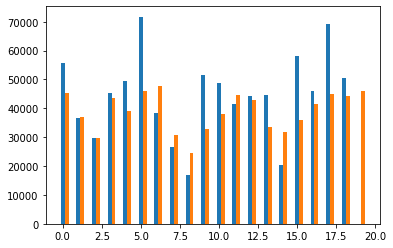

In [20]:
x = np.arange(20)
plt.bar(x, testY.reshape(-1)[-20:],  width = 0.25)
plt.bar(x+0.25, testPredict.reshape(-1)[-20:],  width = 0.25)